In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
np.set_printoptions(suppress = True)

# 第十三章

## 零、练一练

```{admonition} 练一练
请单独对df2.Date的优化步骤进行计时比较，即剔除df2.Company处理的消耗时间，并比较astype操作和rename_categories操作的耗时量。
```

In [2]:
df1 = pd.read_csv('data/ch13/company.csv')
df2 = pd.read_csv('data/ch13/company-data.csv')

In [3]:
%timeit df2.Date.str[:4]

213 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit df2.Date.astype("category")

57.4 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
temp = df2.Date.astype("category")
%timeit temp.cat.rename_categories(dict(zip(temp.cat.categories, [i for i in range(2008,2017)])))

218 µs ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


```{admonition} 练一练
思考“把大象放进冰箱”案例的打印输出，完成以下任务：
- 反复执行上述代码中map()处理的一行，其打印内容的顺序是否会变化？请解释原因。
- 修改put_into_refrigerator()方法，使得打开2号大象冰箱门的时间早于打开1号冰箱门的时间，并且关闭2号门的时间晚于1号门。
```

- 1

可能会变化，因为第一个大象装进冰箱的操作和第二个大象装进冰箱的操作是独立的，谁先完成某个操作（一共有三种操作）就谁先打印。但是需要注意，同一个进程内的打印顺序是确定的。

- 2

```python
def put_into_refrigerator(elephant):
    time.sleep(3 if int(elephant[0]) == 1 else 0.1)
    print("打开冰箱门，准备把"+"%s"%elephant+"装到冰箱")
    time.sleep(0.1)
    print("把"+"%s"%elephant+"装进冰箱")
    time.sleep(0.1 if int(elephant[0]) == 1 else 5)
    print("关闭%s的冰箱门"%elephant)
    return elephant
```

```{admonition} 练一练
观察图13.1结果，回答以下问题：
- 上述代码生成的图中，红色线和蓝色线的交叉点代表了什么含义？
- 随着N的增加，蓝色线会一直保持水平吗？请用实验说明。
```

- 1

若N_iter增加，则多进程的效率将超过单进程。

- 2

不会，实验如下：

```python
N_iter, L = [int(i) for i in [1e3, 1e4, 1e5, 5e5, 1e6, 5e6, 1e7]], []
for N in N_iter:
    input_para = zip(["%d"%i for i in range(1,11)], [N] * 10)
    temp = 0
    for i in range(10000):
        start = time.time()
        container = p.starmap(put_into_refrigerator_new, input_para)
        end = time.time()
        temp += end - start
    L.append(temp/10000)
plt.plot(N_iter, L)
```

```{admonition} 练一练
绘制多进程版本蒙特卡洛估计消耗时间关于选取不同分块数量block_num的折线图，并在图上添加单进程耗时的水平基准线。
```

```python
p = Pool(8)
np.random.seed(99)
array = np.random.uniform([-1, -1], [1, 1], [int(1e6), 2])
block_nums, L = [100, 10000, 100000, 200000, 500000, 1000000], []
for block_num in block_nums:
    array_new = array.reshape(block_num, -1, 2)
    start = time.time()
    result = p.map(generate_block_y, array_new)
    L.append(time.time() - start)
start = time.time()
result = 0
for a, b in array:
    result += generate_y(a, b)
end = time.time()
no_mp_time = end - start
```

```python
plt.plot(block_nums, L)
plt.hlines(no_mp_time, 0, max(block_nums), colors="red")
```

```{admonition} 练一练
上述案例中，主进程虽然被join()阻塞，但事实上此时仍然可以在异步函数的下方执行主进程自己的计算任务，而不是单纯地进行等待。当主进程计算任务较大时，可以设置分配个子进程的最大进程数为CPU核数减去1，这样能够为主进程的计算保留资源。请结合该情景，构造1个主进程和子进程同步计算的例子。
```

子进程计算前七个数组的同时，主进程计算第八个数组：

```python
def do_something_async(arr):
    return arr.sum()
```

```python
p = Pool(7)
res = [0] * 8
arr = np.random.rand(8, 10)
res[:7] = p.map_async(do_something_async, arr[:7]).get()
res[-1] = arr[-1].sum()
p.close()
p.join()
res
```

```{admonition} 练一练
与Manager中的Array类似，Value对象能够进行单个变量的状态共享，例如mgr_val = mgr.Value('d', 0.0)即定义了1个初始值为0.0的浮点变量，通过mgr_val.value可以访问并修改它的值。现有一个由np.random.rand(1000)生成的浮点数组，请利用多进程的方式，调用函数将数组内的值累加到共享变量mgr_val中并保证进程安全。
```

```python
def value_sum(mgr_value, lock, val):
    with lock:
        mgr_value.value += val
```

```python
# 省略导包

p = Pool(8)
arr = np.random.rand(1000)
mgr = Manager()
mgr_lock = mgr.Lock()
mgr_value = mgr.Value('d', 0.0) # 整型Array
partial_value_sum = partial(value_sum, mgr_value, mgr_lock)
p.map(partial_value_sum, arr)
np.abs(arr.sum() - mgr_value.value) < 1e-8 # 浮点数比较
```

```{admonition} 练一练
阅读并理解在多进程中修改ns.my_list的例子，完成以下问题：
- change_ns_list函数中的锁能否去除？请解释原因。
- 仿照ns.list的案例，修改ns.np_arr和ns.my_df的相应操作。
```

- 1

不能去除，如果不加锁，那么多个进程可能同时获取一个数组进行修改，从而慢进程的修改就会覆盖快进程的修改。

```python
def change_list(lst, idx):
    temp = lst
    temp[idx] = 1
    return temp

def change_ns_list(ns, change_list_idx):
    ns.my_list = change_list(ns.my_list, change_list_idx)
```

```python
# 省略导包
p = Pool(8)
mgr = Manager()
ns = mgr.Namespace() # 实例化
ns.my_list = [0] * 100
partial_change_ns_list = partial(change_ns_list, ns)
p.map(partial_change_ns_list, range(100))
sum(ns.my_list) == 100 # 不相等
```

- 2

```python
def change_element(arr, df, idx):
    temp_arr = arr
    temp_arr[idx] = 0
    temp_df = df
    temp_df.iloc[idx//2, idx%2] = 0
    return temp_arr, temp_df

def change_ns_arr_and_df(lock, ns, idx):
    with lock:
        ns.np_arr, ns.my_df = change_element(ns.np_arr, ns.my_df, idx)
```

```python
p = Pool(8)
mgr = Manager()
mgr_lock = mgr.Lock()
ns = mgr.Namespace()
ns.np_arr = np.array([1, 2, 3, 4])
ns.my_df = pd.DataFrame({"A":[1,2], "B":[3,4]})
partial_change_ns_arr_and_df = partial(change_ns_arr_and_df, mgr_lock, ns)
p.map(partial_change_ns_arr_and_df, [0, 1, 2, 3])
```

```python
ns.np_arr
```

```python
ns.my_df
```

```{admonition} 练一练
在对大型共享数组进行写入时，期间占用的内存量会如何变化？请设计实验说明。
```

与读取时相似，内存平稳。

```python
import time
from multiprocessing import Pool, shared_memory, Lock
import numpy as np
from functools import partial
def f(shape, dtype, name, n):
    my_sm = shared_memory.SharedMemory(name=name)
    arr = np.ndarray(shape=shape, dtype=dtype, buffer=my_sm.buf)
    time.sleep(n)
    part_len = int(1.25e8 / 4)
    for i in range(part_len*n, part_len*(n+1)):
        arr[i] = 0.0
    time.sleep(n)
def init_shared_numpy(l):
    global lock
    lock = l
if __name__ == "__main__":
    lock = Lock()
    p = Pool(4, initializer=init_shared_numpy, initargs=[lock])
    arr = np.random.rand(int(1.25e8))
    shm = shared_memory.SharedMemory(create=True, size=arr.nbytes)
    shm_arr = np.ndarray(shape=arr.shape, dtype=arr.dtype, buffer=shm.buf)
    shm_arr[:] = arr[:]
    time.sleep(5)
    del arr
    f_ = partial(f, shm_arr.shape, shm_arr.dtype, shm.name)
    p.map(f_, range(4))
```

```{admonition} 练一练
请通过实验证明在上述“企图共享”DataFrame的操作中，各进程的rec共享内存，且DataFrame彼此独立。
```

通过性能监视器可以发现内存在构造DataFrame时大量增加，但子进程内构造rec时几乎无增幅。

```python
import time
from multiprocessing import Pool, shared_memory
import numpy as np
from functools import partial
import pandas as pd
def recover_df(shape, dtype, name, n):
    my_sm = shared_memory.SharedMemory(name=name)
    rec = np.recarray(shape=shape, dtype=dtype, buf=my_sm.buf)
    time.sleep(n)
    df = pd.DataFrame(rec, copy=False)
    time.sleep(n)
if __name__ == "__main__":
    p = Pool(8)
    df = pd.DataFrame({"A": np.random.rand(int(2e7))})
    arr = df.to_records()
    shm = shared_memory.SharedMemory(create=True, size=arr.nbytes)
    shm_arr = np.ndarray(shape=arr.shape, dtype=arr.dtype, buffer=shm.buf)
    shm_arr[:] = arr[:]
    time.sleep(5)
    del arr
    f_ = partial(recover_df, shm_arr.shape, shm_arr.dtype, shm.name)
    p.map(f_, [5]*8)
```

```{admonition} 练一练
实现外连接（how="outer"）版本的多进程连接。
```

外连接和左连接是不同的，不能直接把多进程里面的left改为outer，原因如下代码结果所示：

In [6]:
df1 = pd.DataFrame({"key": ["A", "A", "B", "C"]})
df2 = pd.DataFrame({"key": ["A", "B", "B", "D"]})
part1 = df1.iloc[:2].merge(df2, on="key", how="outer")
part2 = df1.iloc[2:].merge(df2, on="key", how="outer")

In [7]:
pd.concat([part1, part2])

,key
0,A
1,A
2,B
3,B
4,D
0,B
1,B
2,C
3,A
4,D


In [8]:
df1.merge(df2, how="outer", on="key")

,key
0,A
1,A
2,B
3,B
4,C
5,D


但是可以如下拆分：

In [9]:
part1_1 = df1.iloc[:2]
part1_2 = df1.iloc[2:]
part2 = df2.loc[~df2.key.isin(df1.key)]
pd.concat([
    part1_1.merge(df2, how="left", on="key"),
    part1_2.merge(df2, how="left", on="key"),
    part1.merge(part2, how="right", on="key")
], ignore_index=True)

,key
0,A
1,A
2,B
3,B
4,C
5,D


```python
def outer_merge(df_a, df_b, how):
    return df_a.merge(df_b, how=how, on="key")
```

```python
data = zip(
    [df1.iloc[:2], df1.iloc[2:], df2.loc[~df2.key.isin(df1.key)]],
    [df2, df2, part2],
    ["left", "left", "right"]
)
p = Pool(3)
res = p.starmap(outer_merge, data)
pd.concat(res, ignore_index=True)
```

```{admonition} 练一练
在第10章中我们学习了resample，并了解到它本质上是一种特殊的分组。请构造1个利用多进程解决resample操作的例子。
```

In [10]:
s = pd.Series(np.random.rand(366), index=pd.date_range("20200101", "20201231"))
s.resample("M").mean()

2020-01-31    0.570909
2020-02-29    0.458160
2020-03-31    0.415039
2020-04-30    0.550043
2020-05-31    0.555079
2020-06-30    0.468469
2020-07-31    0.469930
2020-08-31    0.465624
2020-09-30    0.533202
2020-10-31    0.546478
2020-11-30    0.391546
2020-12-31    0.471282
Freq: M, dtype: float64

```python
def resample_multiprocessing(s):
    return s.resample("M").mean()
```

```python
p = Pool(3)
res = p.map(resample_multiprocessing, [s[:"2020-06"], s[:"2020-06":]])
pd.concat(res)
```


```{admonition} 练一练
在4进程下，重做上述时序滑窗的例子，尽可能简洁地处理滑窗的边界情况。
```

```python
np.random.seed(0)
dr = pd.date_range("20190101", "20201231")
dr = np.sort(np.random.choice(dr, int(400), replace=False))
dr = pd.to_datetime(dr)
s = pd.Series(np.random.randint(0, 100, 400), index=dr)
s.head()
```

```python
def rolling_multi(s, start):
    return s.rolling("10D").sum()[start:]
```

```python
cut_start = [dr[0], dr[100], dr[200], dr[300]]
cut_end = [dr[99], dr[199], dr[299], dr[-1]]
ofst = pd.Timedelta("10D") # offset
adjust = [dr[0], dr[100]-ofst, dr[200]-ofst, dr[300]-ofst, dr[-1]]
p = Pool(4)
data = zip([s[adjust[i]:cut_end[i]] for i in range(4)], cut_start)
res = pd.concat(p.starmap(rolling_multi, data))
res.equals(s.rolling("10D").sum())
```

```{admonition} 练一练
结合上述类型声明的例子，完成以下任务：
- 数组参数声明为float64_t的函数能否接收dtype="float32"的numpy数组？反之是否可行？请用实验说明。
- 若当前的输入数组为test_array = np.random.randint(0, 10, int(1e6))，且用户希望输出的数组类型和输入类型一致，请修改代码实现。（提示：查看np.empty返回数组的类型）
```

- 1

不能，且反之也不能

In [11]:
%load_ext cython

In [12]:
%%cython
cimport numpy as np
import numpy as np

def cy_multiply_64(np.ndarray[np.float64_t, ndim=1] np_array):
    cdef:
        int length = np_array.shape[0]
        np.ndarray[np.float64_t, ndim=1] res = np.empty(length)
        Py_ssize_t i
    for i in range(length):
        res[i] = np_array[i] * 2
    return res

def cy_multiply_32(np.ndarray[np.float32_t, ndim=1] np_array):
    cdef:
        int length = np_array.shape[0]
        np.ndarray[np.float64_t, ndim=1] res = np.empty(length)
        Py_ssize_t i
    for i in range(length):
        res[i] = np_array[i] * 2
    return res

In [13]:
cy_multiply_64(np.array([1.], dtype="float32"))

ValueError: Buffer dtype mismatch, expected 'float64_t' but got 'float'

In [14]:
cy_multiply_32(np.array([1.], dtype="float64"))

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

- 2

In [15]:
%%cython
cimport numpy as np
import numpy as np

def cy_multiply_int(np.ndarray[np.int32_t, ndim=1] np_array):
    cdef:
        int length = np_array.shape[0]
        np.ndarray[np.int32_t, ndim=1] res = np.empty(length, dtype="int32")
        Py_ssize_t i
    for i in range(length):
        res[i] = np_array[i] * 2
    return res

In [16]:
test_array = np.random.randint(0, 10, int(1e6))
res = cy_multiply_int(test_array)
res.dtype

dtype('int32')

```{admonition} 练一练
请用cython实现第八章中str对象上的contains方法（不要求正则）、len方法和zfill方法，并进行性能对比。（提示：对于布尔类型的一维NumPy数组，可以使用np.ndarray[np.npy_bool, ndim=1]声明类型）
```

In [17]:
%%cython
import numpy as np
cimport numpy as np

def str_contains(np.ndarray[np.str, ndim=1] arr, np.str s):
    cdef:
        Py_ssize_t i
        int n = arr.shape[0]
        np.ndarray[np.uint8_t, ndim = 1, cast=True] res = np.empty(n, dtype="bool")
    for i in range(n):
        res[i] = s in arr[i]
    return res

def str_len(np.ndarray[np.str, ndim=1] arr):
    cdef:
        Py_ssize_t i
        int n = arr.shape[0]
        np.ndarray[int, ndim=1] res = np.empty(n, dtype="int32")
    for i in range(n):
        res[i] = len(arr[i])
    return res


def str_zfill(np.ndarray[np.str, ndim=1] arr, int pad):
    cdef:
        Py_ssize_t i
        int n = arr.shape[0]
        np.ndarray[np.str, ndim=1] res = np.empty(n, dtype=object)
    for i in range(n):
        res[i] = "0"*max(0, pad-len(arr[i])) + arr[i]
    return res

In [18]:
arr = np.array(["apple", "banana", "cycle"]).astype("object")
str_contains(arr, "a")

array([ True,  True, False])

In [19]:
str_len(arr)

array([5, 6, 5])

In [20]:
str_zfill(arr, 8)

array(['000apple', '00banana', '000cycle'], dtype=object)

In [21]:
arr = np.array(["".join(np.random.choice(list("1234567890"), 5)) for i in range(int(1e5))])
arr = arr.astype("object")
s = pd.Series(arr)

In [22]:
%timeit str_contains(arr, "1")

2.02 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%timeit s.str.contains("1")

39.6 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit str_len(arr)

469 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%timeit s.str.len()

27.8 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit str_zfill(arr, 10)

13.3 ms ± 474 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit s.str.zfill(10)

31.6 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


```{admonition} 练一练
在数组倍乘的例子中，事实上最耗时的部分在于对结果数组的内存分配，因此此处的多线程性能提高程度有限。如果进行的是无需分配内存或分配少量内存的并行操作，那么就可以获得更为可观的性能提升。请利用构造一个函数计算一个二维（1000*1000）数组的元素和，并与numpy比较性能。
```

In [28]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

cimport numpy as np
import numpy as np
import cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
def sum_2d_array(np.ndarray[double, ndim=2] np_array):
    cdef:
        int n = np_array.shape[0]
        double res = 0.0
        Py_ssize_t i, j
    for i in prange(n, nogil=True):
        for j in range(n):
            res += np_array[i, j]
    return res

In [29]:
arr = np.random.rand(1000, 1000)
%timeit sum_2d_array(arr)

366 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
%timeit arr.sum()

844 µs ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


```{admonition} 练一练
结合上述知识，完成如下练习：
- 构造一个翻转图片的函数，翻转方式turn_type包括上下翻转和左右翻转，其调用方式为turn(img_arr, turn_type)。
- 构造一个旋转图片的函数，其调用方式为rotate(img_arr, angle)，其中angle为顺时针的旋转角度，仅取能够被90整除的整数，即$0,\pm 90,\pm 180,\pm 270,...$等。
```

- 1

In [31]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
from cython.parallel import prange
cimport numpy as np
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_picture_flip(int[:, :, :] arr, np.str turn_type):
    cdef:
        int axis_1, axis_2
        int height = arr.shape[0]
        int width = arr.shape[1]
        int[:, :, :] result = np.empty((height, width, 3), dtype="int32")
        Py_ssize_t i, j
    if turn_type == "up-down":
        for i in prange(width, nogil=True):
            for j in range(height):
                result[i, j, :] = arr[height-i-1, j, :]
    elif turn_type == "left-right":
        for i in prange(height, nogil=True):
            for j in range(width):
                result[i, j, :] = arr[i, width-j-1, :]
    else:
        raise ValueError("turn_type is wrong!")
    return np.asarray(result)

In [32]:
from PIL import Image
img = Image.open("data/ch13/piano.png")
img_arr = np.array(img).astype("int")[:,:,:3]

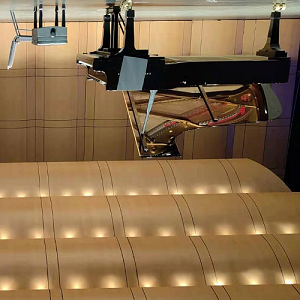

In [33]:
arr_flip = cy_picture_flip(img_arr, "up-down")
Image.fromarray(arr_flip.astype('uint8')).convert('RGB')

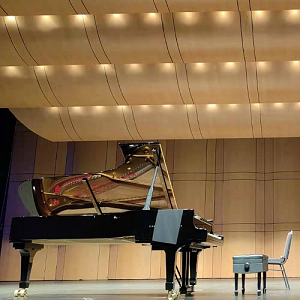

In [34]:
arr_flip = cy_picture_flip(img_arr, "left-right")
Image.fromarray(arr_flip.astype('uint8')).convert('RGB')

- 2

In [35]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
from cython.parallel import prange
cimport numpy as np
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_picture_rotate(int[:, :, :] arr):
    cdef:
        int height = arr.shape[0]
        int width = arr.shape[1]
        int[:, :, :] result = np.empty((width, height, 3), dtype="int32")
        Py_ssize_t i, j
    for i in prange(width, nogil=True):
        for j in range(height):
            result[i, j, :] = arr[width-j-1, i, :]
    return np.asarray(result)

In [36]:
def rotate(img, angle):
    if angle % 90 != 0:
        raise ValueError("wrong angle!")
    while angle != 0:
        img = cy_picture_rotate(img)
        angle += 90 if angle < 0 else -90
    return img

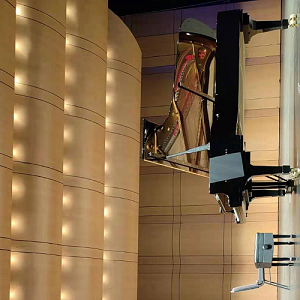

In [37]:
arr_flip = rotate(img_arr, 270)
Image.fromarray(arr_flip.astype('uint8')).convert('RGB')

```{admonition} 练一练
若字符串为my_string，则my_string.count("x")可以统计字符串中字符x的个数。现有一个长度为$10^7$的字符串，其中的字符仅包含a、b、c、d、e、f、g，请使用Cython的多线程操作统计字符a的个数，并与Python字符串上的内置函数count比较性能。
```

In [38]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
#distutils: language = c++
import numpy as np
cimport numpy as np
from cython.parallel import prange
from libcpp.string cimport string
from libcpp.vector cimport vector

cdef extern from "Python.h":
    const char* PyUnicode_AsUTF8(object unicode)

def multi_thread_count(np.str _s, np.str _c):
    cdef:
        Py_ssize_t i
        int n = len(_s)
        int count = 0
        string s = <string>PyUnicode_AsUTF8(_s)
        string c = <string>PyUnicode_AsUTF8(_c)
    for i in prange(n, nogil=True):
        if s[i] == c[0]:
            count += 1
    return count

In [39]:
s = "".join(np.random.choice(list("abcdefg"), int(1e7)))
multi_thread_count(s, "a") == s.count("a")

True

In [40]:
%timeit s.count("a")

20.3 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit multi_thread_count(s, "a")

15.6 ms ± 749 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


````{admonition} 练一练
给定一个含有缺失值的一维数组，假设其首元素非缺失值，请按照如下规则从头到尾依次进行填充：
- 若当前元素非缺失值，则直接保留。
- 若当前元素为缺失值且元素在数组中的索引（从0计数）小于k（$k>=2$），则使用当前位置前所有元素的均值填充，如果之前元素在原数组为缺失值，则使用其填充的值。
- 若当前元素为缺失值且元素在数组中的索引不小于k，则使用当前元素之前k个位置的元素均值进行填充，如果之前元素在原数组为缺失值，则使用其填充的值。
下面给出了两个例子：

```python3
>>> k = 4
>>> arr = np.array([1, np.nan, np.nan, 4, 5, np.nan, np.nan, 7, np.nan])
>>> fill_arr(arr, k)
array([1.        , 1.        , 1.        , 4.        , 5.        ,
       3.33333333, 4.11111111, 7.        , 4.81481481])
```

```python3
>>> k = 5
>>> arr = np.array([2, np.nan, 4, np.nan, 6, np.nan, 8, np.nan])
>>> fill_arr(arr, k)
array([2.        , 2.        , 4.        , 2.66666667, 6.        ,
       3.33333333, 8.        , 4.8       ])
```
````

In [42]:
from numba import njit
@njit
def fill_arr(arr, k):
    n = arr.shape[0]
    for i in range(n):
        if np.isnan(arr[i]):
            temp_sum = 0
            for j in range(max(0, i-k), i):
                temp_sum += arr[j]
            arr[i] = temp_sum / (i - max(0, i-k))
    return arr

```{admonition} 练一练
完成如下问题：
- 请基于numba实现与本小节开头np.add案例功能类似的vectorize版本。
- 请再构造1个利用向量化装饰器自定义ufunc进行广播操作的例子。
```

- 1

In [43]:
from numba import vectorize
@vectorize(nopython=True)
def vec_add(a, b):
    return a + b
arr1 = np.array([1, 2])
arr2 = np.array([[1], [2]])
vec_add(arr1, arr2)

array([[2, 3],
       [3, 4]], dtype=int64)

- 2

In [44]:
from numba import vectorize
@vectorize(nopython=True)
def vec_power_sum(a, b):
    return a**2 + b**2
arr1 = np.array([1, 2])
arr2 = np.array([[1], [2]])
vec_power_sum(arr1, arr2)

array([[2, 5],
       [5, 8]], dtype=int64)

```{admonition} 练一练
请用向量化装饰器对n对矩阵同时进行矩阵乘法的操作，即给定$n\times k_1\times k_2$和$n\times k_2\times k_3$的2个数组，按照外层维度对2个数组相应位置的矩阵进行矩阵乘法，返回结果为$n\times k_1\times k_3$的数组。
```

In [45]:
from numba import guvectorize
@guvectorize(["(float64[:, :], float64[:, :], float64[:, :])"],
              "(n,p),(p,m)->(n,m)", nopython=True)
def numba_matrix_multiply(A, B, res):
    res[:, :] = np.ascontiguousarray(A).dot(np.ascontiguousarray(B))
A = np.random.rand(100, 300, 500)
B = np.random.rand(100, 500, 400)
nb_res = numba_matrix_multiply(A, B)
np_res = np.matmul(A, B)
np.equal(nb_res, np_res).all()

True

In [46]:
%timeit numba_matrix_multiply(A, B)

249 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit np.matmul(A, B)

251 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 一、DNA链的碱基序列处理

DNA是由脱氧核苷酸组成的大分子聚合物。其中，构成脱氧核苷酸的碱基种类有：腺嘌呤（A）、鸟嘌呤（G）、胸腺嘧啶（T）和胞嘧啶（C）。DNA具有双链结构，对于其中的某一条链而言，可用字符串代表其碱基序列的组成，例如：“AAGGTTCC”、“GGGGTTTTAGATCCC”等。现有若干DNA单链的字符串序列存储在data/ch13/DNA目录下，请依次按照如下的多进程方案统计每个碱基序列字符串中各种碱基的占序列总长度的比例，其结果按如下格式保存在DataFrame中：

In [48]:
pd.DataFrame({"A":[0.1,0.3,"...",0.3], "C": [0.3,0.4,"...",0.1],
"G": [0.4,0.2,"...",0.2],"T":[0.2,0.1,"...",0.4]},
index=["DNA_0001","DNA_0002","...","DNA_0200"])

,A,C,G,T
DNA_0001,0.1,0.3,0.4,0.2
DNA_0002,0.3,0.4,0.2,0.1
...,...,...,...,...
DNA_0200,0.3,0.1,0.2,0.4


- 对文件使用多进程，即同时处理多个文件。
- 对每个文件中的字符串使用多进程，即每次处理1个文件，但同时处理单链的不同部分。

```text
【解答】
```

- 1

```python
import pandas as pd
import numpy as np
# Windows放到独立py文件中再导入multi_DNA_file函数
def multi_DNA_file(file):
    file_name = "data/ch13/DNA/%s.txt"%file
    with open(file_name, "r") as f:
        s = f.read()
    data = np.array([s.count("A"), s.count("C"), s.count("G"), s.count("T")])
    data = data / data.sum()
    return pd.DataFrame(data[None, :], index=[file], columns=list("ACGT"))
```

```python
from multiprocessing import Pool
p = Pool(8)
files = ["DNA_%04d"%i for i in range(1, 201)]
res = pd.concat(p.map(multi_DNA_file, files))
res.head()
```

- 2

```python
import pandas as pd
import numpy as np
def multi_DNA_seq(s):
    return [s.count("A"), s.count("C"), s.count("G"), s.count("T")]
```

```python
from multiprocessing import Pool
df_res = []
p = Pool(8)
for i in range(1, 201):
    file = "DNA_%04d"%i
    file_name = "data/ch13/DNA/%s.txt"%file
    with open(file_name, "r") as f:
        s = f.read()
    cut = np.linspace(0, len(s), 9).astype("int").tolist()
    cut = zip(cut[:-1], cut[1:])
    cut_s = [s[start:end] for start, end in cut]
    ACGT_res = p.map(multi_DNA_seq, cut_s)
    temp_res = np.zeros(4)
    for r in ACGT_res:
        for j in range(4):
            temp_res[j] += r[j]
    temp_res = temp_res / temp_res.sum()
    df_res.append(pd.DataFrame(temp_res[None, :], index=[file], columns=list("ACGT")))
res = pd.concat(df_res)
res.head()
```

## 二、捕捉电信号的激活态区间

在电子原件中，电信号的激活与失活是一种常见现象，下面在arr中给出了某信号指标的时序数据，从图13.15可以明显看出信号只会在一小段时间区域内被激活，随后又归于失活状态。

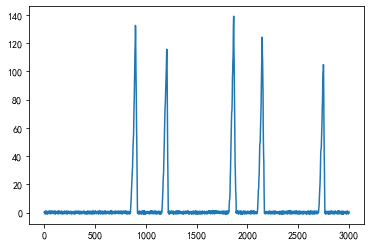

In [49]:
arr = np.load("data/ch13/signal.npy")
plt.plot(range(3000), arr[:3000])

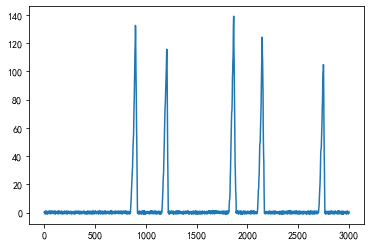

In [50]:
plt.plot(range(3000), arr[:3000])
plt.savefig("_static/ch13/13-15.svg")

```{figure} ../source/_static/ch13/13-15.svg
---
width: 250px
align: center
---
图13.15 某段电信号的时序图
```

对于某个信号而言，如果它自身的信号值小于1，但其后面的连续5个值大于1，则认为当前时刻为激活态的开始时刻；如果它自身的信号值小于1，但其之前的连续5个值大于1，则认为当前时刻为激活态的结束时刻。现在想要统计所有激活状态信号段的开始时刻和结束时刻，并将结果以如下格式保存在df_result中，其中第一列是表示信号段编号，第二和第三列表示开始和结束时的数组索引。

In [51]:
pd.DataFrame({"Signal Number":[0,1,"..."], "Start Index": [100,300,"..."],
"End Index": [200,400,"..."]})

,Signal Number,Start Index,End Index
0,0,100,200
1,1,300,400
2,...,...,...


```text
【解答】
```

- 方法一

In [52]:
arr = np.load("data/ch13/signal.npy")
idx = np.arange(arr.shape[0])
start = np.stack([arr<1] + [np.roll(arr, -i)>1 for i in range(1,6)])
start_res = start.all(0)
end = np.stack([arr<1] + [np.roll(arr, i)>1 for i in range(1,6)])
end_res = end.all(0)
res = pd.DataFrame({
    "Signal Number": np.arange(start_res.sum()),
    "Start Index": idx[start_res],
    "End Index": idx[end_res]
})
res.head()

,Signal Number,Start Index,End Index
0,0,848,916
1,1,1158,1221
2,2,1818,1890
3,3,2098,2167
4,4,2702,2764


- 方法二

In [53]:
from numba import njit

@njit()
def count_signal(arr):
    # 预分配内存，但事实上arr.shape[0]位置的值可以利用一些方法
    # 得到大幅的减少，从而加快分配速度，请读者自行思考
    start = np.full(arr.shape[0], -1)
    end = np.full(arr.shape[0], -1)
    pointer = 0
    for i in range(arr.shape[0]):
        cur = arr[i]
        start_res = cur < 1
        for j in range(1,6):
            start_res &= arr[i+j] > 1
        if start_res:
            start[pointer] = i
        end_res = cur < 1
        for j in range(1,6):
            end_res &= arr[i-j] > 1
        if end_res:
            end[pointer] = i
            pointer += 1
    return start[:pointer], end[:pointer]
arr = np.load("data/ch13/signal.npy")
start_res, end_res = count_signal(arr)
res = pd.DataFrame({
    "Signal Number": np.arange(start_res.shape[0]),
    "Start Index": start_res,
    "End Index": end_res
})
res.head()

,Signal Number,Start Index,End Index
0,0,848,916
1,1,1158,1221
2,2,1818,1890
3,3,2098,2167
4,4,2702,2764


```{note}
Numba中虽然支持list相关的操作，但是尽量用预分配的数组加指针操作来代替，这样会有较大的性能优势。
```

## 三、药物靶点的关联性分析

药物与靶点间的关联性分析是生物信息学中重要的研究课题，图分析是其常见的分析手段之一，将药物和靶点都看作图的节点，若已知某些药物和靶点间存在关联，那么就将它们之间用边连接，记图中边的集合为$E$。图能够用邻接矩阵表示，如果2个节点有连接则记为1，否则记为0，从而我们能够得到drug-target的邻接矩阵。同样地，药物和药物之间、靶点和靶点之间也有关联性作用，我们也用边将关联的节点进行连接，得到drug-drug邻接矩阵、target-target邻接矩阵。2个相连的节点被称为邻居，某一个节点A的邻居集合可以用$N(A)$表示，其邻居个数用$\vert N(A)\vert$表示。在定义了3类连接关系之后，现在需要对所有药物和所有靶点间的相关性进行度量，定义药物$i$（用$D_i$表示）和靶点$j$（用$T_i$表示）之间的关联性指数$S$：

$$
S(D_i, T_j) = \begin{cases}  
1 & D_iT_j \in E \\
\frac{\sum_{Node\in N(D_i)}\mathbb{I}_{\{Node\in N(T_j)\}}}{2\vert N(D_i)\vert}  + 
\frac{\sum_{Node\in N(T_j)}\mathbb{I}_{\{Node\in N(D_i)\}}}{2\vert N(T_j)\vert} 
& Otherwise
\end{cases}
$$

其中，$\mathbb{I}_{\{Node\in N(T_j)\}}$表示事件“节点Node是否为$T_j$邻居”的示性函数，当Node为$T_j$的邻居时取1，否则取0。请根据drug-drug关联图、target-target关联图以及drug-target关联图，计算与所有药物与靶点间的关联性指数。

In [54]:
d_d = np.load("data/ch13/drug-drug.npy")
t_t = np.load("data/ch13/target-target.npy")
d_t = np.load("data/ch13/drug-target.npy")
d_d.shape, t_t.shape, d_t.shape

((1285, 1285), (947, 947), (1285, 947))

```text
【解答】
```

In [55]:
%%cython
# distutils: language = c++
from libcpp.set cimport set
from libcpp.vector cimport vector
import numpy as np
cimport numpy as np
from cython import boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
def get_S(int[:, :] d_d, int[:, :] t_t, int[:, :] d_t):

    cdef:
        int i, j, d, t, status, d_count, t_count
        double d_val, t_val
        int d_dim = d_d.shape[0]
        int t_dim = t_t.shape[0]
        double[:, :] S = np.empty_like(d_t, dtype="float64")
        vector[set[int]] drug_adj, target_adj
        
    for i in range(d_dim):
        drug_adj.push_back(set[int]())
        for j in range(d_dim):
            if d_d[i][j] == 1:
                drug_adj[i].insert(j)

    for i in range(t_dim):
        target_adj.push_back(set[int]())
        for j in range(t_dim):
            if t_t[i][j] == 1:
                target_adj[i].insert(j)

    for i in range(d_dim):
        for j in range(t_dim):
            if d_t[i][j] != 1:
                d_count = 0
                for d in drug_adj[i]:
                    status = target_adj[j].find(d) != target_adj[j].end()
                    d_count = d_count + status
                d_val = d_count / 2 / drug_adj[i].size()
                t_count = 0
                for t in target_adj[j]:
                    status = drug_adj[i].find(t) != drug_adj[i].end()
                    t_count = t_count + status
                t_val = t_count / 2 / target_adj[j].size()
                S[i][j] = d_val + t_val
            else:
                S[i][j] = 1.0
    return np.asarray(S)

In [56]:
res = get_S(d_d, t_t, d_t)
res.shape

(1285, 947)

In [57]:
res

array([[1.        , 1.        , 0.49382489, ..., 1.        , 0.48400228,
        0.46562896],
       [1.        , 1.        , 0.43233035, ..., 1.        , 0.47512593,
        0.48020263],
       [1.        , 0.47275641, 1.        , ..., 0.47479795, 1.        ,
        0.46192308],
       ...,
       [1.        , 1.        , 0.4585027 , ..., 1.        , 0.44824454,
        1.        ],
       [1.        , 0.46980228, 1.        , ..., 0.48324323, 0.48054512,
        1.        ],
       [0.44290555, 0.45630646, 0.47551222, ..., 0.46900691, 0.45473435,
        1.        ]])

## 四、物质浓度的指标检测

某种目标物质（Target）的浓度可能会随环境中其他化合物的浓度而变化，现有某种仪器可以估计溶液中的各类化合物（Compound）浓度和该种目标物质（Target）的浓度。但由于技术原因，无法对这些化合物的浓度给出精确值，只能给出其浓度上界（CUB）与浓度下界（CLB），这些信息被记录在df1中：

In [58]:
df1 = pd.read_csv("data/ch13/compounds.csv")
df1.head()

,Compound,CLB,CUB,Target
0,0,9.050615e+08,9.050625e+08,683757.555164
1,0,9.017325e+08,9.017341e+08,814346.610163
2,0,9.039452e+08,9.039458e+08,719260.326997
3,0,9.041625e+08,9.041632e+08,240696.203722
4,0,9.045420e+08,9.045422e+08,133284.734789


现想要根据compounds表中的信息，推断某些化合物浓度下的Target浓度：对于predict表中的每一行数据，找到compounds表中相同化合物，且浓度区间包含该行中给定化合物浓度的所在记录，当记录条数为0时，predict表中该行的Target_Prediction保持缺失值，当记录条数非0时，predict表中的Target_Prediction用这些记录中目标物质Target的浓度均值进行填充。

In [59]:
df2 = pd.read_csv("data/ch13/predict-target.csv")
df2.head()

,Compound,Concentration,Target_Prediction
0,0,9.055589e+08,NaN
1,0,9.024043e+08,NaN
2,0,8.997355e+08,NaN
3,0,9.014674e+08,NaN
4,0,9.048319e+08,NaN


```text
【解答】
```

```python
import pandas as pd
import numpy as np
from multiprocessing import Pool, shared_memory, Array, Value
from functools import partial

from numba import njit, prange
@njit(parallel=True)
def _compute(c, low, up, t):
    n, m = c.shape[0], t.shape[0]
    res = np.empty(n, dtype="float64")
    for i in prange(n):
        temp = 0
        count = 0
        for j in range(m):
            if c[i] >= low[j] and c[i] <= up[j]:
                temp += t[j]
                count += 1
        res[i] = temp / count if count > 0 else np.nan
    return res

def helper(shape, dtype, name, s):
    my_sm = shared_memory.SharedMemory(name=name)
    arr = np.ndarray(shape=shape, dtype=dtype, buffer=my_sm.buf)
    # 用书上的手工传入lock来锁也是可以的，Value和Array上都可以用get_lock()来加锁
    with visited.get_lock():
        if not visited[s.name]:
            visited[s.name] = True
            with counter.get_lock():
                counter.value += 1
                print("当前已完成：%d/347"%(counter.value))
    return _compute(
        s.values,
        arr[1][arr[0]==s.name],
        arr[2][arr[0]==s.name],
        arr[3][arr[0]==s.name],
    )

def compound_compute(shape, dtype, name, df2):
    partial_helper = partial(helper, shape, dtype, name)
    return df2.groupby("Compound")["Concentration"].transform(partial_helper)

def init_shared(v, c):
    global visited, counter
    visited, counter = v, c

if __name__ == "__main__":

    df1 = pd.read_csv("data/ch13/compounds.csv")
    df2 = pd.read_csv("data/ch13/predict-target.csv")
    visited = Array("i", [0]*347) # 共有347类
    counter = Value("i", 0)
    p = Pool(16, initializer=init_shared, initargs=[visited, counter])
    arr = df1.values.T
    shm = shared_memory.SharedMemory(create=True, size=arr.nbytes)
    shm_arr = np.ndarray(shape=arr.shape, dtype=arr.dtype, buffer=shm.buf)
    shm_arr[:] = arr[:]
    del arr
    partial_compound_compute = partial(
        compound_compute, shm_arr.shape, shm_arr.dtype, shm.name)
    cut = np.linspace(0, df2.shape[0], 17).astype("int")
    data = [df2.iloc[cut[i]: cut[i+1]] for i in range(16)]
    res = pd.concat(p.map(partial_compound_compute, data))
    # res.to_csv("my_result.csv", index=False)
```

## 五、设计滑窗类



请分别用cython的cdef class和numba的jitclass设计1个滑窗类，支持滑动均值、滑动标准差以及滑动最大值的计算，无需考虑时序数据（即普通滑窗），且满足如下要求：

- 注意边界值与缺失值的处理。
- 性能上接近甚至超过Pandas中的滑窗函数。
- 按以下方式调用对象：

```python
# s是需要操作的序列
roller = rolling(data=s.values, window=10)
roller.mean()
roller.std()
roller.max()
```

```text
【解答】
```

在这个问题上Numba速度慢于Cython，但具体问题需要具体分析，实际运用时需要通过实验对比才能定量地说明它们之间的性能优劣。

In [60]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
# cython: boundscheck=False, wraparound=False

import numpy as np
import cython
from cython.parallel import prange
from libc.math cimport INFINITY, NAN, sqrt

cdef class cy_rolling:
    cdef:
        double[:] data
        int window
    def __init__(self, data, window):
        self.data = data
        self.window = window
    def max(self):
        cdef:
            int n = self.data.shape[0]
            int k = self.window
            double temp
            double[:] res = np.empty(n, dtype="float64")
            Py_ssize_t i, j
        res[:k-1] = NAN
        for i in prange(k-1, n, nogil=True):
            temp = -INFINITY
            for j in range(k):
                if self.data[i-j] > temp:
                    temp = self.data[i-j]
            res[i] = temp
        return np.asarray(res)
    def mean(self):
        cdef:
            int n = self.data.shape[0]
            int k = self.window
            double temp
            double[:] res = np.empty(n, dtype="float64")
            Py_ssize_t i, j
        res[:k-1] = NAN
        for i in prange(k-1, n, nogil=True):
            temp = 0.0
            for j in range(k):
                temp = temp + self.data[i-j]
            res[i] = temp / k
        return np.asarray(res)
    def std(self):
        cdef:
            int n = self.data.shape[0]
            int k = self.window
            double sum_val, square_val
            double[:] res = np.empty(n, dtype="float64")
            Py_ssize_t i, j
        res[:k-1] = NAN
        for i in prange(k-1, n, nogil=True):
            sum_val = 0.0
            square_val = 0.0
            for j in range(k):
                sum_val = sum_val + self.data[i-j]
                square_val = square_val + self.data[i-j] * self.data[i-j]
            sum_val = sum_val / k
            res[i] = sqrt(square_val / k - sum_val * sum_val)
        return np.asarray(res)

In [61]:
from numba.experimental import jitclass
from numba import int64, float64

spec = [('window', int64), ('data', float64[:])]
@jitclass(spec)
class nb_rolling(object):
    def __init__(self, data, window):
        self.data = data
        self.window = window
    def max(self):
        n, k = self.data.shape[0], self.window
        res = np.empty(n, dtype="float64")
        res[:k-1] = np.nan
        for i in range(k-1, n):
            temp = -np.inf
            for j in range(k):
                if self.data[i-j] > temp:
                    temp = self.data[i-j]
            res[i] = temp
        return res
    def mean(self):
        n, k = self.data.shape[0], self.window
        res = np.empty(n, dtype="float64")
        res[:k-1] = np.nan
        for i in range(k-1, n):
            res[i] = np.mean(self.data[i-k+1:i+1])
        return res
    def std(self):
        n, k = self.data.shape[0], self.window
        res = np.empty(n, dtype="float64")
        res[:k-1] = np.nan
        for i in range(k-1, n):
            res[i] = np.std(self.data[i-k+1:i+1])
        return res

In [62]:
s = pd.Series(np.random.rand(int(1e7)))
# 可能有计算的浮点误差，此处仅看前5位小数
pd_roller = s.rolling(100)
pd_res_max = pd_roller.max().round(5)
pd_res_mean = pd_roller.mean().round(5)
pd_res_std = pd_roller.std(ddof=0).round(5)
cy_roller = cy_rolling(s.values, 100)
cy_res_max = pd.Series(cy_roller.max()).round(5)
cy_res_mean = pd.Series(cy_roller.mean()).round(5)
cy_res_std = pd.Series(cy_roller.std()).round(5)
nb_roller = nb_rolling(s.values, 100)
nb_res_max = pd.Series(nb_roller.max()).round(5)
nb_res_mean = pd.Series(nb_roller.mean()).round(5)
nb_res_std = pd.Series(nb_roller.std()).round(5)

In [63]:
cy_res_max.equals(pd_res_max)

True

In [64]:
cy_res_mean.equals(pd_res_mean)

True

In [65]:
cy_res_std.equals(pd_res_std)

True

In [66]:
nb_res_max.equals(pd_res_max)

True

In [67]:
nb_res_mean.equals(pd_res_mean)

True

In [68]:
nb_res_std.equals(pd_res_std)

True

In [69]:
%timeit pd_roller.max()

734 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
%timeit cy_roller.max()

452 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%timeit nb_roller.max()

1.42 s ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%timeit pd_roller.mean()

362 ms ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
%timeit cy_roller.mean()

389 ms ± 50.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%timeit nb_roller.mean()

1.1 s ± 62.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%timeit pd_roller.std()

409 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%timeit cy_roller.std()

396 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%timeit nb_roller.std()

2.56 s ± 90.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
